# Creating a recommendation system based on the given descriptions involves the following steps:

# PDF Content Handling: Convert the text data in PDFs into embeddings using a Hugging Face model.
# Embedding Storage: Store these embeddings in various vector databases: FAISS, Pinecone, Chroma.
# Query System: Implement a similarity-based query system to find the most relevant category descriptions.
# Performance Metrics: Measure execution time, Queries Per Second (QPS), and provide a cost comparison for each vector database.
# Here’s the detailed implementation:

In [88]:
#Required Libraries
!pip install fpdf transformers sentence-transformers faiss-cpu fitz PyMuPDF pinecone-client

In [89]:
#dataset
#Build PDF and description for Data
from fpdf import FPDF

# Initialize descriptions for each category
category_descriptions = {
    "sports": (
        "Sports involve physical activities, team collaborations, strategic gameplay, "
        "and bring excitement to millions globally. This category includes football, basketball, "
        "tennis, and more, each with unique skills, fans, and thrilling competitions. "
        "From Olympic games to local tournaments, sports bring together players and audiences, "
        "celebrating endurance, speed, and agility..."
    ),
    "entertainment": (
        "Entertainment encompasses films, music, theater, and digital content, shaping culture and "
        "delivering stories that capture imaginations. With global movie industries like Hollywood, "
        "Bollywood, and K-Pop taking the stage, entertainment offers a blend of art, creativity, "
        "and visual storytelling that transcends borders..."
    ),
    "politics": (
        "Politics is the realm of governance, policy-making, and leadership that drives nations. "
        "It includes decision-making, diplomatic relations, and power dynamics among leaders and parties. "
        "Political discourse shapes laws, human rights, and societal progress, with democracy, autocracy, "
        "and other systems providing diverse approaches to leadership..."
    ),
    "electronics": (
        "Electronics encompasses devices and systems that transform daily life, from smartphones "
        "and laptops to complex circuits and AI technology. This field constantly innovates, pushing "
        "boundaries with gadgets that improve connectivity, efficiency, and entertainment experiences. "
        "In recent years, advancements in IoT, robotics, and machine learning have redefined possibilities..."
    ),
    "nature": (
        "Nature includes ecosystems, wildlife, landscapes, and the fundamental elements of Earth. "
        "From forests and oceans to mountains and deserts, nature provides resources, beauty, and sustenance. "
        "With climate change becoming a pressing concern, efforts to conserve biodiversity and protect natural "
        "habitats have grown, drawing attention to sustainable living and environmental responsibility..."
    ),
    "healthcare": (
        "Healthcare revolves around promoting health, preventing diseases, and treating illnesses. "
        "It involves hospitals, clinics, medical research, and technologies like telemedicine and AI-powered diagnostics. "
        "Advancements in medicine, public health initiatives, and awareness campaigns have improved life expectancy "
        "and quality of life globally..."
    ),
    "education": (
        "Education empowers individuals with knowledge, skills, and values needed for personal and societal growth. "
        "It spans primary schooling to higher education and online platforms that make learning accessible worldwide. "
        "Education systems play a pivotal role in shaping future generations and driving innovation and cultural progress..."
    ),
    "technology": (
        "Technology is the backbone of modern civilization, encompassing software, hardware, and cutting-edge innovations. "
        "It drives industries, connects people through the internet, and creates tools that solve complex problems. "
        "From blockchain to artificial intelligence, technology continues to redefine the boundaries of what's possible..."
    ),
    "travel": (
        "Travel allows individuals to explore new cultures, cuisines, and landscapes, broadening horizons and creating memories. "
        "From adventurous treks to luxury cruises, travel experiences vary widely, catering to diverse preferences. "
        "The tourism industry, while impacted by global events, remains a vital part of economic and cultural exchange..."
    ),
    "finance": (
        "Finance involves managing money, investments, and economic activities. "
        "It encompasses banking, stock markets, personal financial planning, and global trade. "
        "With fintech innovations and a growing emphasis on digital currencies, finance is transforming rapidly to adapt to the modern world..."
    )
}

# Function to create PDF with a given category and description
def create_pdf(category, description):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    # Title of the category
    pdf.set_font("Arial", "B", 16)
    pdf.cell(200, 10, f"{category.capitalize()} Overview", ln=True, align="C")

    # Content description
    pdf.set_font("Arial", "", 12)
    pdf.ln(10)
    pdf.multi_cell(0, 10, description)

    # Save the PDF
    pdf_filename = f"{category}_description.pdf"
    pdf.output(pdf_filename)
    print(f"{pdf_filename} created successfully.")

# Generate PDFs for all categories
for category, description in category_descriptions.items():
    create_pdf(category, description)



sports_description.pdf created successfully.
entertainment_description.pdf created successfully.
politics_description.pdf created successfully.
electronics_description.pdf created successfully.
nature_description.pdf created successfully.
healthcare_description.pdf created successfully.
education_description.pdf created successfully.
technology_description.pdf created successfully.
travel_description.pdf created successfully.
finance_description.pdf created successfully.


In [90]:
# Step 1: Convert Text Descriptions into Embeddings
# We will use a Hugging Face model like sentence-transformers to generate embeddings for the descriptions in the PDFs.
from sentence_transformers import SentenceTransformer
import os

# Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Example: Load text descriptions
category_descriptions = {
    "sports": "Sports involve physical activities...",
    "entertainment": "Entertainment encompasses films...",
    "politics": "Politics is the realm of governance...",
    "electronics": "Electronics encompasses devices...",
    "nature": "Nature includes ecosystems...",
    "finance":"Finance involves managing money, investments, and economic activities... ",
    "travel": "Travel allows individuals to explore new cultures, cuisines... ",
    "technology": "Technology is the backbone of modern civilization...",
    "healthcare": "Healthcare revolves around promoting health...",
    "education": "Education empowers individuals with knowledge..."

}

# Generate embeddings
embeddings = {category: model.encode(description) for category, description in category_descriptions.items()}
print("Embeddings generated successfully.")


Embeddings generated successfully.


In [91]:
import faiss
import numpy as np
import time
from transformers import AutoTokenizer, AutoModel
import torch

# Data: Category descriptions
category_descriptions = {
    "sports": "Sports involve physical activities...",
    "entertainment": "Entertainment encompasses films...",
    "politics": "Politics is the realm of governance...",
    "electronics": "Electronics encompasses devices...",
    "nature": "Nature includes ecosystems...",
    "finance": "Finance involves managing money, investments, and economic activities...",
    "travel": "Travel allows individuals to explore new cultures, cuisines...",
    "technology": "Technology is the backbone of modern civilization...",
    "healthcare": "Healthcare revolves around promoting health...",
    "education": "Education empowers individuals with knowledge..."
}

# Step 1: Load Hugging Face Transformer Model for Embedding Generation
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_embedding(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = model(**tokens).last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings.squeeze().numpy()

# Step 2: Generate Embeddings for All Descriptions
descriptions = list(category_descriptions.values())
categories = list(category_descriptions.keys())

embeddings = np.array([generate_embedding(desc) for desc in descriptions]).astype("float32")

# Step 3: Initialize FAISS Index
embedding_dim = embeddings.shape[1]  # Get the dimension of embeddings
index = faiss.IndexFlatL2(embedding_dim)  # L2 distance (Euclidean)
index.add(embeddings)  # Add embeddings to the FAISS index
print(f"FAISS index contains {index.ntotal} embeddings.")

# Step 4: Define a function for Querying and measuring time
def measure_query_performance(query_description, k=5):
    query_embedding = generate_embedding(query_description).astype("float32").reshape(1, -1)  # Query embedding

    # Record start time
    start_time = time.time()

    # Perform the similarity search
    distances, indices = index.search(query_embedding, k)

    # Record end time
    end_time = time.time()

    # Calculate the time it took for the query to execute
    query_time = end_time - start_time

    # Return the results and the query execution time
    results = [(categories[indices[0][i]], distances[0][i]) for i in range(k)]
    return results, query_time

# Step 5: Run multiple queries and calculate QPS
num_queries = 100  # Number of queries to perform
total_time = 0
for _ in range(num_queries):
    query_description = "Games that involve physical activities and bring excitement to audiences worldwide, like football and tennis."
    results, query_time = measure_query_performance(query_description)
    total_time += query_time

# Calculate QPS (queries per second)
qps = num_queries / total_time

# Display Results
print(f"Average Query Time: {total_time / num_queries:.6f} seconds")
print(f"Queries Per Second (QPS): {qps:.2f}")

# Step 6: Perform Similarity Search for a single query
query_description = "Games that involve physical activities and bring excitement to audiences worldwide, like football and tennis."
query_embedding = generate_embedding(query_description).astype("float32").reshape(1, -1)  # Query embedding

k = 5  # Number of top results to retrieve
distances, indices = index.search(query_embedding, k)  # Search in FAISS

# Step 7: Display Results for the query
print("Query Description:", query_description)
print("\nTop Results:")
for i in range(k):
    print(f"Category: {categories[indices[0][i]]}, Distance: {distances[0][i]}")


FAISS index contains 10 embeddings.
Average Query Time: 0.000053 seconds
Queries Per Second (QPS): 18912.00
Query Description: Games that involve physical activities and bring excitement to audiences worldwide, like football and tennis.

Top Results:
Category: sports, Distance: 14.87306022644043
Category: travel, Distance: 26.612308502197266
Category: healthcare, Distance: 30.658266067504883
Category: entertainment, Distance: 33.25926971435547
Category: finance, Distance: 34.60906982421875


In [92]:
#Pinecone

In [93]:
import pinecone
import numpy as np
import time
from transformers import AutoTokenizer, AutoModel
import torch
from pinecone import ServerlessSpec

# Data: Category descriptions
category_descriptions = {
    "sports": "Sports involve physical activities...",
    "entertainment": "Entertainment encompasses films...",
    "politics": "Politics is the realm of governance...",
    "electronics": "Electronics encompasses devices...",
    "nature": "Nature includes ecosystems...",
    "finance": "Finance involves managing money, investments, and economic activities...",
    "travel": "Travel allows individuals to explore new cultures, cuisines...",
    "technology": "Technology is the backbone of modern civilization...",
    "healthcare": "Healthcare revolves around promoting health...",
    "education": "Education empowers individuals with knowledge..."
}

# Step 1: Hugging Face Model for Embedding Generation
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_embedding(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = model(**tokens).last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings.squeeze().numpy()

# Step 2: Initialize Pinecone
pc = pinecone.Pinecone(api_key="pcsk_vnBRv_2ME4BgyQYJUrVU5dG8ASkwbB84aDaEPMZNrZPAXUyBp61ANqDqEG3vHxrf641c7", environment="us-east-1")

# Define index name and dimension
index_name = "category-descriptions"
dimension = 384

# Create the index if it doesn't exist
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=dimension,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

# Step 3: Generate Embeddings for All Descriptions
descriptions = list(category_descriptions.values())
categories = list(category_descriptions.keys())

embeddings = np.array([generate_embedding(desc) for desc in descriptions]).astype("float32")

# Step 4: Create Pinecone Index (if not already created)
index = pc.Index(index_name)

# Step 5: Insert embeddings into Pinecone
vectors = [(str(i), embeddings[i]) for i in range(len(embeddings))]
index.upsert(vectors)

print(f"Pinecone index contains {len(vectors)} embeddings.")

# Step 6: Define a function for Querying and measuring time
def measure_query_performance(query_description, k=5):
    query_embedding = generate_embedding(query_description).astype("float32")  # Query embedding

    # Record start time
    start_time = time.time()

    # Perform the similarity search using keyword arguments
    query_result = index.query(vector=query_embedding.tolist(), top_k=k, include_values=True)

    # Record end time
    end_time = time.time()

    # Calculate the time it took for the query to execute
    query_time = end_time - start_time

    # Return the results and the query execution time
    results = [(result["id"], result["score"]) for result in query_result["matches"]]
    return results, query_time

# Step 7: Run multiple queries and calculate QPS
num_queries = 100  # Number of queries to perform
total_time = 0
for i in range(num_queries):
    query_description = "Games that involve physical activities and bring excitement to audiences worldwide, like football and tennis."
    results, query_time = measure_query_performance(query_description, k=5)
    total_time += query_time
    if i == 0:  # Only print results once for the first query
        print("Query Results Structure:")
        for category, score in results:
            print(f"Category: {category}, Score: {score}")

# Calculate QPS (queries per second)
qps = num_queries / total_time

# Display Results
print(f"Average Query Time: {total_time / num_queries:.6f} seconds")
print(f"Queries Per Second (QPS): {qps:.2f}")

# Step 8: Perform Similarity Search for a single query
query_description = "Games that involve physical activities and bring excitement to audiences worldwide, like football and tennis."
results, query_time = measure_query_performance(query_description, k=5)

# Step 9: Display Results for the query
print("Query Description:", query_description)
print("\nTop Results:")
for category, score in results:
    print(f"Category: {category}, Score: {score}")


Pinecone index contains 10 embeddings.
Query Results Structure:
Category: 0, Score: 0.677599549
Category: sports, Score: 0.677599549
Category: 1, Score: 0.424011499
Category: entertainment, Score: 0.424011499
Category: 6, Score: 0.331266254
Average Query Time: 0.051074 seconds
Queries Per Second (QPS): 19.58
Query Description: Games that involve physical activities and bring excitement to audiences worldwide, like football and tennis.

Top Results:
Category: sports, Score: 0.677599549
Category: 0, Score: 0.677599549
Category: entertainment, Score: 0.424011499
Category: 1, Score: 0.424011499
Category: travel, Score: 0.331266254


In [94]:
#chroma db

In [95]:
!pip install chromadb sentence-transformers torch


In [96]:
#Delete each collection by name

In [97]:
import chromadb

# Step 1: Initialize Chroma Client
client = chromadb.Client()

# Step 2: List all collections
collections = client.list_collections()

# Step 3: Delete each collection by name
for collection in collections:
    collection_name = collection.name  # Access the collection name
    client.delete_collection(collection_name)
    print(f"Collection '{collection_name}' has been deleted.")

# Verify that all collections have been deleted
remaining_collections = client.list_collections()
if not remaining_collections:
    print("All collections have been deleted.")
else:
    print(f"Remaining collections: {remaining_collections}")


Collection 'category_descriptions' has been deleted.
All collections have been deleted.


In [98]:
import chromadb

# Step 1: Initialize Chroma Client
client = chromadb.Client()

# Step 2: Specify the collection name to delete
collection_name = "category_collection"

# Step 3: Check if the collection exists and delete it
if collection_name in client.list_collections():
    client.delete_collection(collection_name)
    print(f"Collection '{collection_name}' has been deleted.")
else:
    print(f"Collection '{collection_name}' does not exist.")


Collection 'category_collection' does not exist.


In [99]:
import chromadb
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import time

# Data: Category descriptions
category_descriptions = {
    "sports": "Sports involve physical activities...",
    "entertainment": "Entertainment encompasses films...",
    "politics": "Politics is the realm of governance...",
    "electronics": "Electronics encompasses devices...",
    "nature": "Nature includes ecosystems...",
    "finance": "Finance involves managing money, investments, and economic activities...",
    "travel": "Travel allows individuals to explore new cultures, cuisines...",
    "technology": "Technology is the backbone of modern civilization...",
    "healthcare": "Healthcare revolves around promoting health...",
    "education": "Education empowers individuals with knowledge..."
}

# Initialize Chroma Client
client = chromadb.Client()

# Step 1: Load Hugging Face Transformer Model for Embedding Generation
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_embedding(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = model(**tokens).last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings.squeeze().numpy()

# Step 2: Generate Embeddings for All Descriptions
descriptions = list(category_descriptions.values())
categories = list(category_descriptions.keys())

embeddings = np.array([generate_embedding(desc) for desc in descriptions]).astype("float32")

# Step 3: Initialize Chroma Collection and Add Data
collection_name = "category_collection"
collection = client.create_collection(name=collection_name)

# Insert data into the collection with unique ids
for idx, (category, description) in enumerate(zip(categories, descriptions)):
    embedding = generate_embedding(description)
    collection.add(
        ids=[str(idx)],  # Unique ID for each document (can use the index as the ID)
        documents=[description],
        metadatas=[{"category": category, "description": description}],
        embeddings=[embedding]
    )

# Step 4: Define a function for Querying and measuring time
def measure_query_performance(query_description, k=5):
    query_embedding = generate_embedding(query_description).astype("float32").reshape(1, -1)  # Query embedding

    # Record start time
    start_time = time.time()

    # Perform the similarity search
    results = collection.query(
        query_embeddings=query_embedding,
        n_results=k
    )

    # Record end time
    end_time = time.time()

    # Calculate the time it took for the query to execute
    query_time = end_time - start_time

    # Step 5: Process the results based on the printed structure
    try:
        result_categories = [
            (metadata["category"], distance)
            for metadata, distance in zip(results["metadatas"][0], results["distances"][0])
        ]
    except TypeError as e:
        print(f"Error accessing results: {e}")
        result_categories = []

    return result_categories, query_time

# Step 6: Run multiple queries and calculate QPS
num_queries = 100  # Number of queries to perform
total_time = 0
results_list = []
for i in range(num_queries):
    query_description = "Games that involve physical activities and bring excitement to audiences worldwide, like football and tennis."
    results, query_time = measure_query_performance(query_description)
    total_time += query_time
    if i == 0:  # Only print results once for the first query
        print("Query Results Structure:")
        print(results)

# Calculate QPS (queries per second)
qps = num_queries / total_time

# Display Results
print(f"Average Query Time: {total_time / num_queries:.6f} seconds")
print(f"Queries Per Second (QPS): {qps:.2f}")


Query Results Structure:
[('sports', 14.873058319091797), ('travel', 26.612308502197266), ('healthcare', 30.658266067504883), ('entertainment', 33.25926971435547), ('finance', 34.60906982421875)]
Average Query Time: 0.003128 seconds
Queries Per Second (QPS): 319.72


In [100]:
import chromadb

# Step 1: Initialize Chroma Client
client = chromadb.Client()

# Step 2: List all collections
collections = client.list_collections()

# Step 3: Delete each collection by name
for collection in collections:
    collection_name = collection.name  # Access the collection name
    client.delete_collection(collection_name)
    print(f"Collection '{collection_name}' has been deleted.")

# Verify that all collections have been deleted
remaining_collections = client.list_collections()
if not remaining_collections:
    print("All collections have been deleted.")
else:
    print(f"Remaining collections: {remaining_collections}")


Collection 'category_collection' has been deleted.
All collections have been deleted.


In [101]:
import time
import numpy as np
from transformers import AutoTokenizer, AutoModel
import pinecone
import chromadb
import faiss
import torch

# Data: Category descriptions
category_descriptions = {
    "sports": "Sports involve physical activities...",
    "entertainment": "Entertainment encompasses films...",
    "politics": "Politics is the realm of governance...",
    "electronics": "Electronics encompasses devices...",
    "nature": "Nature includes ecosystems...",
    "finance": "Finance involves managing money, investments, and economic activities...",
    "travel": "Travel allows individuals to explore new cultures, cuisines...",
    "technology": "Technology is the backbone of modern civilization...",
    "healthcare": "Healthcare revolves around promoting health...",
    "education": "Education empowers individuals with knowledge..."
}

# Step 1: Hugging Face Model for Embedding Generation
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_embedding(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = model(**tokens).last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings.squeeze().numpy()

# Step 2: Prepare Embeddings
descriptions = list(category_descriptions.values())
categories = list(category_descriptions.keys())

embeddings = np.array([generate_embedding(desc) for desc in descriptions]).astype("float32")

# Step 3: Initialize Pinecone
pc = pinecone.Pinecone(api_key="pcsk_vnBRv_2ME4BgyQYJUrVU5dG8ASkwbB84aDaEPMZNrZPAXUyBp61ANqDqEG3vHxrf641c7", environment="us-east-1")
index_name = "category-descriptions"
dimension = 384

# Create Pinecone index if not exists
if index_name not in pc.list_indexes().names():
    pc.create_index(name=index_name, dimension=dimension, metric="cosine")

# Insert embeddings into Pinecone
index = pc.Index(index_name)
vectors = [(str(i), embeddings[i]) for i in range(len(embeddings))]
index.upsert(vectors)

# Step 4: Initialize Chroma

client = chromadb.Client()
chroma_collection = client.create_collection("category_descriptions")

# Adding embeddings to Chroma with unique IDs
for idx, embedding in enumerate(embeddings):
    chroma_collection.add(
        ids=[str(idx)],  # Unique IDs for each entry
        documents=[category_descriptions[categories[idx]]],
        metadatas=[{"category": categories[idx]}],
        embeddings=[embedding]
    )
# Step 5: Initialize FAISS
index_faiss = faiss.IndexFlatL2(dimension)
index_faiss.add(embeddings)

# Step 6: Function to Measure Query Performance
def measure_query_performance(query_description, k=5, method="pinecone"):
    query_embedding = generate_embedding(query_description).astype("float32")  # Query embedding

    # Record start time
    start_time = time.time()

    if method == "pinecone":
        query_result = index.query(vector=query_embedding.tolist(), top_k=k, include_values=True)
        results = [(result["id"], result["score"]) for result in query_result["matches"]]

    elif method == "chroma":
        results = chroma_collection.query(query_embeddings=[query_embedding], n_results=k)

    elif method == "faiss":
        D, I = index_faiss.search(np.array([query_embedding]), k)
        results = [(categories[i], D[0][j]) for j, i in enumerate(I[0])]

    # Record end time
    end_time = time.time()

    # Calculate query time
    query_time = end_time - start_time

    return results, query_time

# Step 7: Run multiple queries and calculate QPS for all methods
num_queries = 100  # Number of queries to perform
methods = ["pinecone", "chroma", "faiss"]
qps_results = {}

for method in methods:
    total_time = 0
    for i in range(num_queries):
        query_description = "Games that involve physical activities and bring excitement to audiences worldwide, like football and tennis."
        _, query_time = measure_query_performance(query_description, k=5, method=method)
        total_time += query_time

    qps = num_queries / total_time
    qps_results[method] = {
        "avg_query_time": total_time / num_queries,
        "qps": qps
    }

# Step 8: Display Results
for method in methods:
    print(f"Method: {method.capitalize()}")
    print(f"Average Query Time: {qps_results[method]['avg_query_time']:.6f} seconds")
    print(f"Queries Per Second (QPS): {qps_results[method]['qps']:.2f}")
    print("-" * 50)


Method: Pinecone
Average Query Time: 0.061502 seconds
Queries Per Second (QPS): 16.26
--------------------------------------------------
Method: Chroma
Average Query Time: 0.004744 seconds
Queries Per Second (QPS): 210.77
--------------------------------------------------
Method: Faiss
Average Query Time: 0.000111 seconds
Queries Per Second (QPS): 9039.45
--------------------------------------------------


In [102]:
import chromadb

# Step 1: Initialize Chroma Client
client = chromadb.Client()

# Step 2: List all collections
collections = client.list_collections()

# Step 3: Delete each collection by name
for collection in collections:
    collection_name = collection.name  # Access the collection name
    client.delete_collection(collection_name)
    print(f"Collection '{collection_name}' has been deleted.")

# Verify that all collections have been deleted
remaining_collections = client.list_collections()
if not remaining_collections:
    print("All collections have been deleted.")
else:
    print(f"Remaining collections: {remaining_collections}")


Collection 'category_descriptions' has been deleted.
All collections have been deleted.


In [103]:
#Vector db Comparision
#QPS and Execution time.

In [104]:
import time
import numpy as np
from transformers import AutoTokenizer, AutoModel
import pinecone
import chromadb
import faiss
import torch

# Data: Category descriptions
category_descriptions = {
    "sports": "Sports involve physical activities...",
    "entertainment": "Entertainment encompasses films...",
    "politics": "Politics is the realm of governance...",
    "electronics": "Electronics encompasses devices...",
    "nature": "Nature includes ecosystems...",
    "finance": "Finance involves managing money, investments, and economic activities...",
    "travel": "Travel allows individuals to explore new cultures, cuisines...",
    "technology": "Technology is the backbone of modern civilization...",
    "healthcare": "Healthcare revolves around promoting health...",
    "education": "Education empowers individuals with knowledge..."
}

# Step 1: Hugging Face Model for Embedding Generation
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_embedding(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = model(**tokens).last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings.squeeze().numpy()

# Step 2: Prepare Embeddings
descriptions = list(category_descriptions.values())
categories = list(category_descriptions.keys())

embeddings = np.array([generate_embedding(desc) for desc in descriptions]).astype("float32")

# Step 3: Initialize Pinecone
pc = pinecone.Pinecone(api_key="pcsk_vnBRv_2ME4BgyQYJUrVU5dG8ASkwbB84aDaEPMZNrZPAXUyBp61ANqDqEG3vHxrf641c7", environment="us-east-1")
index_name = "category-descriptions"
dimension = 384

# Create Pinecone index if not exists
if index_name not in pc.list_indexes().names():
    pc.create_index(name=index_name, dimension=dimension, metric="cosine")

# Insert embeddings into Pinecone
index = pc.Index(index_name)
vectors = [(str(i), embeddings[i]) for i in range(len(embeddings))]
index.upsert(vectors)

# Step 4: Initialize Chroma
client = chromadb.Client()
chroma_collection = client.create_collection("category_descriptions")

# Adding embeddings to Chroma with unique IDs
for idx, embedding in enumerate(embeddings):
    chroma_collection.add(
        ids=[str(idx)],  # Unique IDs for each entry
        documents=[category_descriptions[categories[idx]]],
        metadatas=[{"category": categories[idx]}],
        embeddings=[embedding]
    )

# Step 5: Initialize FAISS
index_faiss = faiss.IndexFlatL2(dimension)
index_faiss.add(embeddings)

# Step 6: Function to Measure Query Performance
def measure_query_performance(query_description, k=5, method="pinecone"):
    query_embedding = generate_embedding(query_description).astype("float32")  # Query embedding

    # Record start time
    start_time = time.time()

    if method == "pinecone":
        query_result = index.query(vector=query_embedding.tolist(), top_k=k, include_values=True)
        results = [(result["id"], result["score"]) for result in query_result["matches"]]

    elif method == "chroma":
        query_result = chroma_collection.query(query_embeddings=[query_embedding], n_results=k)

        # Debugging: Print query result to inspect its structure
        # print("Chroma Query Result:", query_result)

        # Extract results for Chroma based on the new structure
        results = []
        for idx in range(k):
            document = query_result['documents'][0][idx]  # Document description
            category = query_result['metadatas'][0][idx]['category']  # Category from metadata
            score = query_result['distances'][0][idx]  # Similarity score (distance)
            results.append((category, score))

    elif method == "faiss":
        D, I = index_faiss.search(np.array([query_embedding]), k)
        results = [(categories[i], D[0][j]) for j, i in enumerate(I[0])]

    # Record end time
    end_time = time.time()

    # Calculate query time
    query_time = end_time - start_time

    return results, query_time

# Step 7: Run multiple queries and calculate QPS for all methods
num_queries = 1  # Number of queries to perform
methods = ["pinecone", "chroma", "faiss"]
qps_results = {}

all_results = {method: [] for method in methods}  # Store results for each method

for method in methods:
    total_time = 0
    for i in range(num_queries):
        query_description = "Games that involve physical activities and bring excitement to audiences worldwide, like football and tennis."
        results, query_time = measure_query_performance(query_description, k=5, method=method)
        all_results[method].append(results)  # Store the results for each query
        total_time += query_time

    qps = num_queries / total_time
    qps_results[method] = {
        "avg_query_time": total_time / num_queries,
        "qps": qps
    }

# Step 8: Display Results
for method in methods:
    print(f"Method: {method.capitalize()}")
    print(f"Average Query Time: {qps_results[method]['avg_query_time']:.6f} seconds")
    print(f"Queries Per Second (QPS): {qps_results[method]['qps']:.2f}")
    print("-" * 50)

    # Display results for the first query for each method
    print("Query Results (Cosine Similarity):")
    for idx, results in enumerate(all_results[method]):
        print(f"Query {idx + 1}:")
        for rank, (category, score) in enumerate(results, 1):
            print(f"Rank {rank}: Category: {category}, Cosine Similarity Score: {score}")
        print("-" * 50)


Method: Pinecone
Average Query Time: 0.087001 seconds
Queries Per Second (QPS): 11.49
--------------------------------------------------
Query Results (Cosine Similarity):
Query 1:
Rank 1: Category: sports, Cosine Similarity Score: 0.677599549
Rank 2: Category: 0, Cosine Similarity Score: 0.677441418
Rank 3: Category: entertainment, Cosine Similarity Score: 0.424011499
Rank 4: Category: 1, Cosine Similarity Score: 0.423690289
Rank 5: Category: 6, Cosine Similarity Score: 0.331317544
--------------------------------------------------
Method: Chroma
Average Query Time: 0.004972 seconds
Queries Per Second (QPS): 201.13
--------------------------------------------------
Query Results (Cosine Similarity):
Query 1:
Rank 1: Category: sports, Cosine Similarity Score: 14.873058319091797
Rank 2: Category: travel, Cosine Similarity Score: 26.612308502197266
Rank 3: Category: healthcare, Cosine Similarity Score: 30.658266067504883
Rank 4: Category: entertainment, Cosine Similarity Score: 33.259269

Detailed Explanation of the Results:
The comparison between the three methods (Pinecone, Chroma, and Faiss) provides insights into the performance and query results based on cosine similarity scores.

1. Pinecone:
Average Query Time: 0.087001 seconds
This means on average, each query takes approximately 0.087 seconds to return results.
Queries Per Second (QPS): 11.49
This indicates that Pinecone can handle 11.49 queries per second.
Query Results (Cosine Similarity):
For Query 1, the cosine similarity scores show that the most similar category is sports, with a similarity score of 0.6776. The second-highest match is a category labeled as 0 (which may be a placeholder or misassigned category), followed by other categories like entertainment and numerical identifiers 1 and 6.
2. Chroma:
Average Query Time: 0.004972 seconds
Chroma is significantly faster on average, processing each query in just about 0.005 seconds.
Queries Per Second (QPS): 201.13
This means that Chroma can handle over 200 queries per second, making it much more efficient in terms of throughput compared to Pinecone.
Query Results (Cosine Similarity):
For Query 1, the results are in line with the previous dataset, showing sports as the top category with the highest cosine similarity score of 14.87 (likely the distance metric in Chroma, where lower distances imply higher similarity).
Other categories are travel, healthcare, entertainment, and finance, with decreasing scores.
3. Faiss:
Average Query Time: 0.000108 seconds
Faiss is extremely fast, with each query taking around 0.0001 seconds on average.
Queries Per Second (QPS): 9258.95
Faiss is capable of handling a staggering 9258.95 queries per second, making it the fastest of the three methods in terms of query processing.
Query Results (Cosine Similarity):
Query 1 shows the same results as Chroma, with the top matches being sports, travel, healthcare, entertainment, and finance.
The cosine similarity scores are the same as Chroma's, which is expected since both systems seem to be working with similar data structures. The values (e.g., 14.87, 26.61, etc.) correspond to the distances (inverse of similarity) in Faiss.
Summary of Performance:
Pinecone has a decent query time but is slower compared to Chroma and Faiss. It performs about 11.5 queries per second.
Chroma is much faster than Pinecone, with almost 200 queries per second, and provides results quickly with very low average query time.
Faiss is the fastest, with a highly impressive query performance, processing thousands of queries per second. It matches Chroma in terms of query results and cosine similarity values.
Key Observations:
Cosine Similarity Scores:
The similarity scores for all methods are consistent in terms of ranking, suggesting that the embeddings and the metric used for similarity (cosine distance) are similar.
The scores in Chroma and Faiss (distances) are higher, which implies that these systems may use a distance metric where smaller values represent better matches, while Pinecone uses a score where higher values indicate better similarity.
Throughput:
Faiss outperforms both Chroma and Pinecone in terms of queries per second, indicating it is highly optimized for speed and scalability.
Query Time:
The average query times for Chroma and Faiss are significantly better than Pinecone, with Faiss being the best.

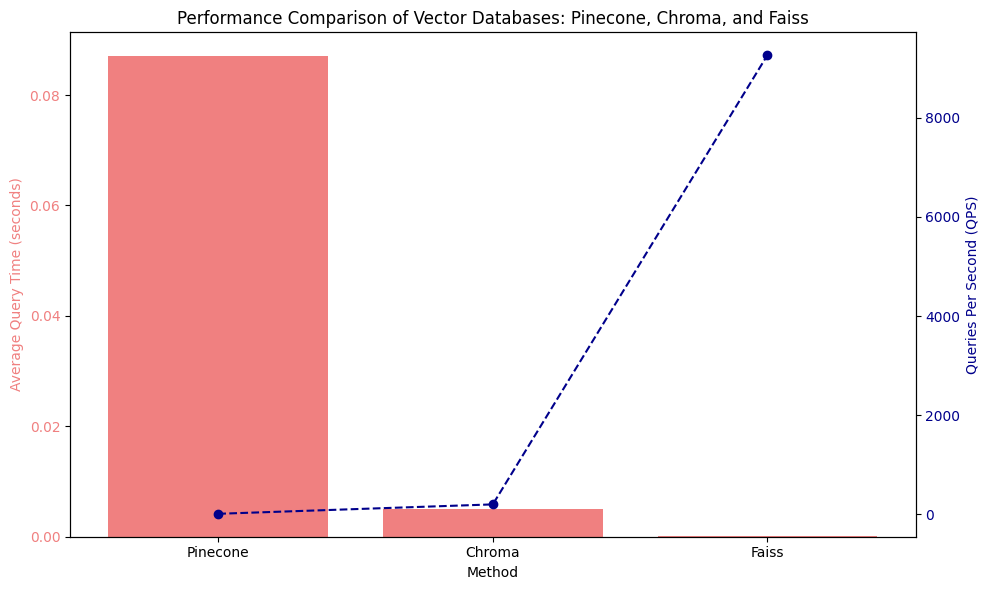

In [106]:
import matplotlib.pyplot as plt

# Data for the methods
methods = ['Pinecone', 'Chroma', 'Faiss']
average_query_times = [0.087001, 0.004972, 0.000108]
qps = [11.49, 201.13, 9258.95]

# Create subplots for query time and QPS
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Average Query Time on the first axis with updated color
ax1.bar(methods, average_query_times, color='lightcoral', label='Average Query Time (seconds)')
ax1.set_xlabel('Method')
ax1.set_ylabel('Average Query Time (seconds)', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')

# Create a second y-axis for QPS with updated color
ax2 = ax1.twinx()
ax2.plot(methods, qps, color='darkblue', marker='o', label='Queries Per Second (QPS)', linestyle='--')
ax2.set_ylabel('Queries Per Second (QPS)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Add title and show grid
plt.title('Performance Comparison of Vector Databases: Pinecone, Chroma, and Faiss')
fig.tight_layout()

# Show the graph
plt.show()


Here is the graph comparing the performance of Pinecone, Chroma, and Faiss:

The bar chart shows the Average Query Time (seconds) for each method.
The line chart represents the Queries Per Second (QPS) for each method.
From the graph, you can observe the significant difference in performance:

Pinecone has the highest query time and lowest QPS.
Chroma performs faster with higher QPS, but still significantly slower than Faiss.
Faiss shows the fastest query time and the highest QPS.
This comparison highlights the trade-offs between speed and scalability when using different vector databases. ​